In [4]:
#imports base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import seaborn as sns
import warnings
import random

#sklearn utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#models
from sklearn.cluster import SpectralClustering
#from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
#from pyearth import Earth
#from lightgbm import LGBMRegressor

In [9]:
#configuracion
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("PuBuGn_d"))
warnings.filterwarnings('ignore')
sys.path.append('/home/ubuntu/fastai/')
%matplotlib inline

#pathdata
PATH_DATA = '/home/ubuntu/fastai/data/'
PATH      = '/home/ubuntu/fastai/cajamar2018/'

In [14]:
import pickle
df_mod = pickle.load(open('dataframe_processed.pkl','rb'))
numerical_vars, categorical_vars, TARGET = pickle.load(open('vars.pkl','rb'))

----
----
# Enfoque deep

In [10]:
import torch
import fastai

from fastai.structured import *
from fastai.column_data import *


def exp_mae(y_pred, targ):
    return np.average(np.abs( np.exp(y_pred) -  np.exp(targ)), axis=0)


def exp_rmspe(y_pred, targ):
    targ = np.exp(targ)
    pct_var = (targ -  np.exp(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [15]:
df_deep = df_mod.drop(['ID_Customer'], axis=1)

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [17]:
#NECESITARÍAMOS PODER VOLVER AL VALOR DE CADA CATEGORÍA
df_deep[categorical_vars] = df_deep[categorical_vars].apply(lambda x: le.fit_transform(x))

In [18]:
for v in categorical_vars: df_deep[v] = df_deep[v].astype('category').cat.as_ordered()
for v in numerical_vars: df_deep[v] = df_deep[v].astype('float32')

In [19]:
X_full, y_full, nas, mapper = proc_df(df_deep, TARGET, do_scale=True)

In [20]:
max_y = np.max(y_full)
y_range = (0, max_y*1.2)

In [21]:
X_train, X_val, y_train, y_val   = train_test_split(X_full, y_full, test_size=0.10, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [22]:
samp_size   = X_train.shape[0]
train_ratio = 0.8
train_size  = int(samp_size * train_ratio); train_size
test_idx    = random.sample(range(0, samp_size), train_size)

In [23]:
cat_sz = [(c, len(df_mod[c].cat.categories)+1) for c in categorical_vars]
#cat_sz

In [24]:
emb_szs = [(c, min(52, (c+1)//2)) for _,c in cat_sz]
#emb_szs

In [25]:
md = ColumnarModelData.from_data_frame(PATH, test_idx, X_train, y_train, cat_flds=categorical_vars, bs=128, test_df=X_val)

In [26]:
m = md.get_learner(emb_szs, len(X_full.columns)-len(categorical_vars),
                   0.5, 1, [800,800, 500], [0.1,0.25, 0.5], y_range=y_range)

In [28]:
m.fit(1e-3, 10, metrics=[exp_mae, exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   exp_mae    exp_rmspe        
    0      0.139262   0.125151   4691.178711 0.397744  
    1      0.13356    0.132484   4939.038086 0.381497        
    2      0.129477   0.124481   4676.44043 0.373269         
    3      0.133168   0.125253   4652.318359 0.403623        
    4      0.124718   0.127753   4712.945801 0.401238        
    5      0.127347   0.124612   4720.345215 0.35897         
    6      0.124035   0.119467   4605.179688 0.390087        
    7      0.122093   0.124054   4697.671875 0.385388        
    8      0.122865   0.123162   4650.050781 0.359611        
    9      0.117781   0.121461   4669.320801 0.377977        



[0.12146059, array([4669.321], dtype=float32), 0.37797700059822026]

In [29]:
dl_preds = m.predict(is_test=True)

dl:  4660.47


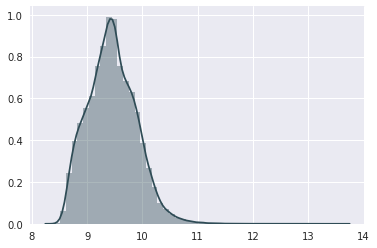

In [30]:
print('dl: ', round(mean_absolute_error(np.exp(y_val), np.exp(dl_preds)), 3))
sns.distplot(dl_preds)

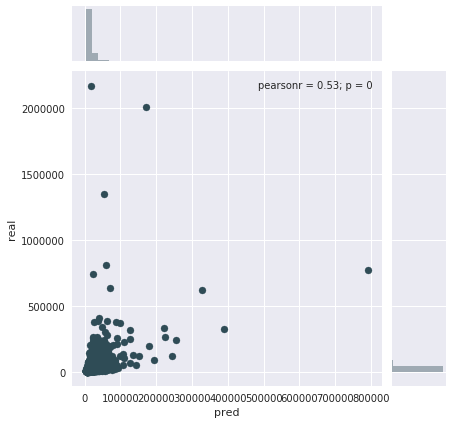

In [38]:
d2plot = pd.DataFrame(np.column_stack((np.exp(dl_preds), np.exp(y_val))))
d2plot.columns=['pred', 'real']
sns.jointplot(x='pred', y='real', data=d2plot)

----
----
Enfoque tradicional

In [ ]:
df_dummies = pd.get_dummies(df_mod, columns=categorical_vars)

In [ ]:
X_full = df_dummies.drop(['ID_Customer', TARGET], axis=1)
y_full = df_dummies[TARGET]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [ ]:
catboost = CatBoostRegressor(learning_rate=0.1, depth=10, loss_function='RMSE', l2_leaf_reg=20, od_pval = 0.01)
catboost = catboost.fit(X_train, y_train, eval_set=(X_test, y_test))
catboots_preds = catboost.predict(X_val)

In [ ]:
lm = LinearRegression(normalize=True)
lm = lm.fit(X_train, y_train)
lm_preds = lm.predict(X_val)

In [ ]:
#print('Catboost: ', round(mean_absolute_error(np.exp(y_val),np.exp(catboots_preds)), 3))
print('lm: ', round(mean_absolute_error(np.exp(y_val), np.exp(lm_preds)), 3))
#print('earth: ', round(mean_absolute_error(y_test, earth_preds), 3))

In [ ]:
#diagrama de densidada del poder adquisitivo
sns.distplot(df_mod[TARGET], color='#009999')

In [ ]:
sns.distplot(lm_preds, color='#009999')

In [ ]:
sns.distplot(catboots_preds)